# Visualize $\mu$ and $\rho$

## Module load

In [36]:
using Pkg
#pkg"add Plots, LaTeXStrings, Graphs, GraphRecipes, JLD2, Distributions, Random, PyPlot, PyCall, Clustering, SparseArrays"
#pkg"add https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl"
Pkg.activate(".")
Pkg.update()
Pkg.status()

  Activating project at `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/backward_messages`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl`
  No Changes to `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/backward_messages/Project.toml`
  No Changes to `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/backward_messages/Manifest.toml`


Status `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/backward_messages/Project.toml`
  [aaaa29a8] Clustering v0.15.8
  [31c24e10] Distributions v0.25.116
  [bd48cda9] GraphRecipes v0.5.13
  [86223c79] Graphs v1.12.0
  [033835bb] JLD2 v0.5.10
  [b964fa9f] LaTeXStrings v1.4.0
  [91a5bcdd] Plots v1.40.9
  [438e738f] PyCall v1.96.4
  [d330b81b] PyPlot v2.11.5
  [1607259e] SmallCouplingDynamicCavity v4.0.2 `https://github.com/Mattiatarabolo/SmallCouplingDynamicCavity.jl#main`
  [9a3f8284] Random
  [2f01184e] SparseArrays v1.10.0


In [37]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions
using SparseArrays
using Random
using JLD2
import PyPlot as plt 
using PyCall
using Clustering

In [38]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t-1
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end


function extract_ρ_cav(i::Int, j::Int, nodes, model, γ)
    @assert i!=j
    @assert i<=length(nodes)
    @assert j<=length(nodes)

    # Initialize prior probabilities based on the expected mean number of source patients (γ)
    prior = zeros(SmallCouplingDynamicCavity.n_states(model.Disease), model.N)
    @inbounds @fastmath @simd for i in 1:model.N
        prior[1, i] = 1 - γ # x_i = S
        prior[2, i] = γ # x_i = I
    end

    # Initialize message objects
    M = SmallCouplingDynamicCavity.TransMat(model.T, model.Disease)
    ρ = SmallCouplingDynamicCavity.FBm(model.T, model.Disease)
    sumargexp = SmallCouplingDynamicCavity.SumM(model.T)

    # Compute the cavity messages
    iindex = nodes[j].∂_idx[i]
    jindex = nodes[i].∂_idx[j]
    SmallCouplingDynamicCavity.compute_sumargexp!(nodes[i], nodes, sumargexp, model)
    SmallCouplingDynamicCavity.compute_ρ!(nodes[i], iindex, nodes[j], jindex, sumargexp, M, ρ, prior, model)

    return ρ
end

function normalize!(ρ)
    @inbounds @fastmath @simd for t in 1:size(ρ.fwm)[2]
        ρ.fwm[:, t] /= sum(ρ.fwm[:, t])
        ρ.bwm[:, t] /= sum(ρ.bwm[:, t])
    end
end

function meshgrid(x,y)
    nx=length(x)
    ny=length(y)
    X=zeros(ny,nx)
    Y=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            X[ix,jx]=x[jx]
            Y[ix,jx]=y[ix]
        end
    end
    return X, Y
end

meshgrid (generic function with 1 method)

## $\rho$ visualization

### Data loading

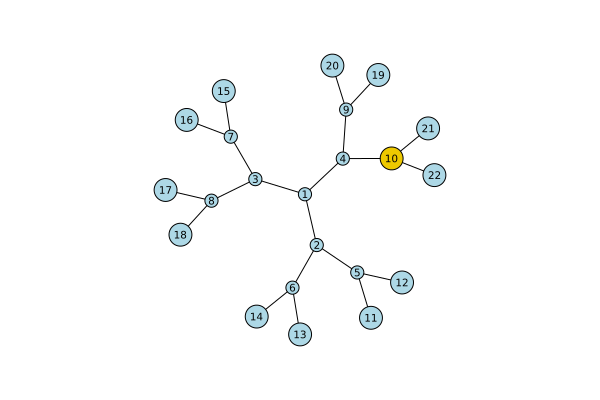

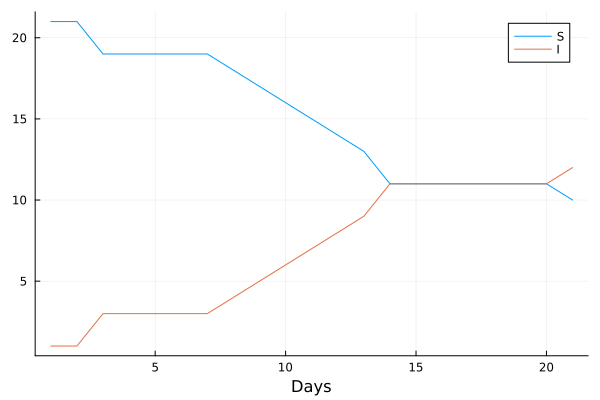

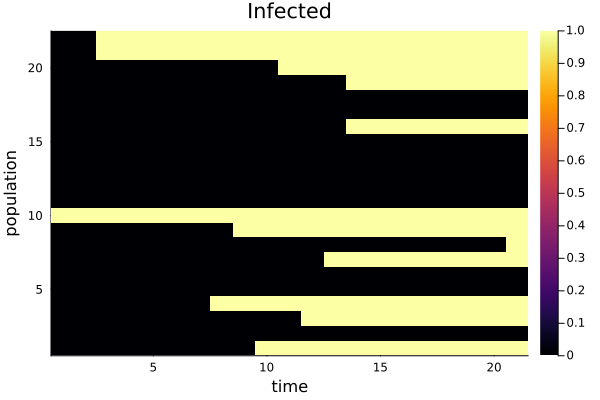

Matrix{Int8} (alias for Array{Int8, 2})

In [39]:
data = load("rho_supershort_tree.jld2")
G = data["G"]
NV = nv(G)
config = data["config"]
T = data["T"]
λ₀ = data["lambda"]
γ = 1/NV # Patient zero probability
observed = data["observed"]

isource = findall(x->x==1.0,config[:,1])

cols = [:blues for _ in 1:NV]
cols[isource] .= :gold2

display(graphplot(G,names=1:NV,edgecolor=:black,curves=false,markercolor=cols,nodeshape=:circle, markersize =.2))

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0),config), dims = 1), dims = 1)
#nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI], xlabel = "Days", ylabel = "", label = ["S" "I"]))

# display epidemy
display(heatmap(config,title="Infected",xlabel="time",ylabel="population")) 
typeof(config)

### Inference SCDC-- autoinfection, $\mu$ cutoff

In [40]:
# computational constants
epsconv = 5e-5 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.0 # damping factor
μ_cutoff = -Inf
ε_autoinf = 0.0

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

report (generic function with 1 method)

xᵢ(t=8) = 0
[(1, 8)]
i = 1 ε = 1.0
i = 2 ε = 0.8489180809232602
i = 3 ε = 0.5659622567887137
i = 4 ε = 0.09549750691191422
i = 5 ε = 0.033337050217214115
i = 6 ε = 0.0
xᵢ(t=12) = 1
[(1, 12)]
i = 1 ε = 0.9545454545454546
i = 2 ε = 0.7862022077387423
i = 3 ε = 0.5659622567887137
i = 4 ε = 0.12406569857942662
i = 5 ε = 0.11598704952087285
i = 6 ε = 0.0


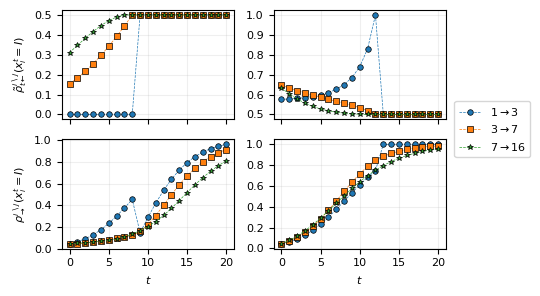

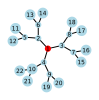

"/Users/mattiatarabolo/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/backward_messages/rhos_backward_graph.pdf"

In [41]:
mark = ["o", "s", "*"]
col = ["C0","C1", "C2"]

paths = [(1,3), (3,7), (7,16)]

fig, ax = plt.subplots(2, 2, figsize=(4.6, 3), sharex=true, tight_layout=true)
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

######## Observed Susceptible ##############
t_obs = 8 #ceil(Int,T/2)+

# generate observations
obsmat_S = ones(Int8, NV, T+1) * (-1)
obslist_S = Vector{Tuple{Int,Int}}()
for iₗ in observed
    obsmat_S[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    println("xᵢ(t=$(t_obs)) = $(config[iₗ, t_obs+1])")
    push!(obslist_S, (iₗ, ceil(Int,t_obs)))
end
println(obslist_S)

# insert the observations into the model structure
model.obsmat .= obsmat_S

nodes_S = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

for (index,(i,j)) in enumerate(paths)
    ρ = extract_ρ_cav(i, j, nodes_S, model, γ)
    normalize!(ρ)
    ax[1].plot(0:T, ρ.bwm[2,:], label=L"%$i \rightarrow %$j", linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
    ax[2].plot(0:T, ρ.fwm[2,:], linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
end
ax[2].set_xlabel(L"t")
ax[1].set_ylabel(L"\tilde{\rho}_{t\leftarrow}^{i\setminus j}(x_i^t=I)")
ax[2].set_ylabel(L"\rho_{\rightarrow}^{i\setminus j}(x_i^t=I)")
ax[1].set_yticks(0:.1:.5)
ax[2].set_yticks(0:.2:1)
#ax[1].set_ylabel(L"\rho_{t\leftarrow}^{i\setminus j}(x_i^t=I)")
#ax[1].legend()



######### Observed Infected ###################
t_obs = 12 #ceil(Int,T/2)+

# generate observations
obsmat_I = ones(Int8, NV, T+1) * (-1)
obslist_I = Vector{Tuple{Int,Int}}()
for iₗ in observed
    obsmat_I[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    println("xᵢ(t=$(t_obs)) = $(config[iₗ, t_obs+1])")
    push!(obslist_I, (iₗ, ceil(Int,t_obs)))
end
println(obslist_I)

# insert the observations into the model structure
model.obsmat .= obsmat_I

nodes_I = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

for (index,(i,j)) in enumerate(paths)
    ρ = extract_ρ_cav(i, j, nodes_I, model, γ)
    normalize!(ρ)
    ax[3].plot(0:T, ρ.bwm[2,:], linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
    ax[4].plot(0:T, ρ.fwm[2,:], linestyle="--", color=col[index], linewidth=.5, marker=mark[index], markersize=4, markeredgecolor="black", markeredgewidth=.5)
end
ax[4].set_xlabel(L"t")
ax[3].set_yticks(.5:.1:1)
ax[4].set_yticks(0:.2:1)


ax[1].grid(alpha=.2)
ax[2].grid(alpha=.2)
ax[3].grid(alpha=.2)
ax[4].grid(alpha=.2)

fig.legend(
    loc="center left",       # Position the legend at the top center
    bbox_to_anchor=(.98, .563),  # Position slightly above the subplots
    ncol=1,                    # Horizontal arrangement of item
)

fig.savefig("rhos_norm_plot.pdf", bbox_inches="tight")
plt.display_figs()



########### graph plot #####################
gr()
uniform_size = 1  # Adjust this value to change the size of nodes
node_sizes = fill(uniform_size, nv(G))  # Uniform size for all nodes
cols = [:blues for _ in 1:NV]
cols[observed] .= :red
pgraph = graphplot(G, markercolor=cols, dim=2, names=1:NV, node_weights=node_sizes, nodesize=.1, fontsize=4, edgecolor=:black, curves=false, margin=0Plots.mm, nodeshape=:circle, label = "", size=(100,100), markerstrokewidth=-1, markerstrokecolor=:auto, markerstrokealpha=0, axisbuffer=0.07)

display(pgraph)

savefig(pgraph, "rhos_backward_graph.pdf")

## $\mu$ visualization

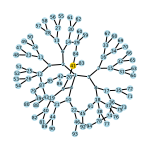

In [42]:
data = load("mus_graph.jld2")

G = data["G"]
isource = data["isource"]
NV = nv(G)
Random.seed!(1998)
cols = [:blues for _ in 1:NV]
cols[isource] .= :gold2
pgraph = graphplot(G, markercolor=cols, names=1:NV, nodesize=.1, fontsize=3, edgecolor=:black, curves=false, margin=0Plots.mm, nodeshape=:circle, label = "", size=(150,150), markerstrokewidth=0, markerstrokecolor=:auto, markerstrokealpha=0, axisbuffer=0.07)
display(pgraph)
#savefig(pgraph, "musgraph_num.pdf")

T = data["T"]
λ₀ = data["lambda"]
γ = 1/NV # Patient zero probability
config = data["config"]
observed1 = data["observed1"]
observed2 = data["observed2"]

mst = SimpleDiGraphFromIterator(kruskal_mst(G))
D = ones(NV,NV) - adjacency_matrix(mst) - adjacency_matrix(mst)' 
cluster_order = hclust(D).order
inv_clust = [findall(x->x==i,cluster_order)[1] for i in 1:NV]
inf_tuple, _, _ = sort_by_infection_time(config, T, NV);

### Generation of observations

In [43]:
t_obs = 25

println(config[12,t_obs+1])
println(config[8,t_obs+1])

1
0


### Inference SCDC-- autoinfection, $\mu$ cutoff

In [44]:
# computational constants
epsconv = 1e-13 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.0 # damping factor
μ_cutoff = -Inf
ε_autoinf = 0.0

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

report (generic function with 1 method)

In [45]:
# generate observations
obsmat1 = ones(NV, T+1) * (-1.0)
obslist1 = []
for iₗ in observed1
    obsmat1[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist1, (iₗ, ceil(Int,t_obs)))
end

# insert the observations into the model structure
model.obsmat .= obsmat1

nodes1 = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob1 = ones(NV, T+1)
for node in nodes1
    marg_prob1[node.i,:] .= node.marg.m[2,:]
end



# generate observations
obsmat2 = ones(NV, T+1) * (-1.0)
obslist2 = []
for iₗ in observed2
    obsmat2[iₗ, t_obs+1] = config[iₗ, t_obs+1]
    push!(obslist2, (iₗ, ceil(Int,t_obs)))
end

# insert the observations into the model structure
model.obsmat .= obsmat2

nodes2 = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob2 = ones(NV, T+1)
for node in nodes2
    marg_prob2[node.i,:] .= node.marg.m[2,:]
end



i = 1 ε = 0.9893617021276596
i = 2 ε = 0.932157742225674
i = 3 ε = 0.7448865453320717
i = 4 ε = 0.5223123538817871
i = 5 ε = 0.3815432732838642
i = 6 ε = 0.24115192725602752
i = 7 ε = 0.14523354903766322
i = 8 ε = 0.05463657413890444
i = 9 ε = 0.02269727887241102
i = 10 ε = 0.014067799690675065
i = 11 ε = 0.009870513629652744
i = 12 ε = 0.0049028504681154494
i = 13 ε = 0.0015570159348833323
i = 14 ε = 0.001241708940511177
i = 15 ε = 0.0009230761261112552
i = 16 ε = 0.000683669906885398
i = 17 ε = 0.00021814993934970994
i = 18 ε = 0.00016484326148014095
i = 19 ε = 6.690872624104394e-5
i = 20 ε = 3.779598975228726e-5
i = 21 ε = 2.907622580999858e-5
i = 22 ε = 1.4457343981311155e-5
i = 23 ε = 1.0030768965885173e-5
i = 24 ε = 5.145349472157612e-6
i = 25 ε = 3.731627668313031e-6
i = 26 ε = 2.5238835258400982e-6
i = 27 ε = 1.6650402051010538e-6
i = 28 ε = 1.4095145499659623e-6
i = 29 ε = 1.0950516881047534e-6
i = 30 ε = 3.63985618534457e-7
i = 31 ε = 1.1179760417423523e-7
i = 32 ε = 8.069265

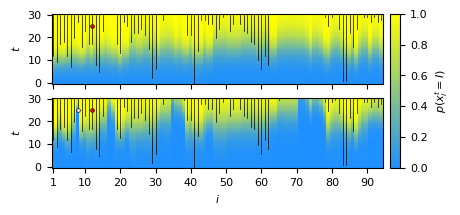

In [46]:
cols = ["white", "red", "black"]

# Custom color gradient
color1 = "dodgerblue"  # Starting color
color2 = "yellow"      # Ending color
# Create a colormap using LinearSegmentedColormap
cm = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(4.6, 2), sharex=true)  # Adjust layout
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  # Set font size

# Define axes
x_edges = .5:(NV + .5)  # Edges for x-axis (0.5 to NV + 0.5)
y_edges = -.5:T+.5  # Edges for y-axis (0 to T)
# Create X, Y coordinate matrices
X, Y = meshgrid(x_edges, y_edges)

# First heatmap (p1)
ax1 = axes[1]
p1 = ax1.pcolor(X, Y, marg_prob1', cmap=cm, vmin=0, vmax=1, edgecolors="none")
ax1.set_ylim(-.5, T+.5)
ax1.set_xlim(.5, NV+.5)
ax1.set_ylabel(L"t")
ax1.set_yticks(0:10:T)

# Plot infection times (p1)
for (i, inf_time_list) in inf_tuple
    for inf_time in inf_time_list
        ax1.plot([i, i], [inf_time[1] - 0.1, inf_time[2] + 0.1], c="black", lw=.5, zorder=1)
    end
end

# Plot observations (p1)
for (i, t) in obslist1
    ax1.scatter(i, t, s=7, c=cols[ceil(Int, config[i, t + 1]) + 1], edgecolor="black", linewidths=0.5, zorder=2)
end

# Second heatmap (p2)
ax2 = axes[2]
p2 = ax2.pcolor(X, Y, marg_prob2', cmap=cm, vmin=0, vmax=1, edgecolors="none",)
ax2.set_ylim(-.5, T+.5)
ax2.set_xlim(.5, NV+.5)
ax2.set_xlabel(L"i")
ax2.set_ylabel(L"t")
ax2.set_xticks(vcat([1], collect(10:10:NV)))
ax2.set_yticks(0:10:T)

# Plot infection times (p2)
for (i, inf_time_list) in inf_tuple
    for inf_time in inf_time_list
        ax2.plot([i, i], [inf_time[1]-.4, inf_time[2]+.4], c="black", lw=.5, zorder=1)
    end
end

# Plot observations (p2)
for (i, t) in obslist2
    ax2.scatter(i, t, s=7, c=cols[ceil(Int, config[i,t+1])+1], edgecolor="black", linewidths=0.5, zorder=2)
end

# Add a single shared colorbar
cbar = fig.colorbar(p2, ax=axes, orientation="vertical", fraction=0.05, pad=0.02, aspect=15)
cbar.set_label(L"p(x_i^t=I)")
cbar.set_ticks(0:.2:1)

plt.display_figs()
# Save the plot
fig.savefig("heatmap_plot.png", format="png", bbox_inches="tight", dpi=2000)


In [47]:
function norm_μ(i::Int,j::Int,nodes::Vector, t::Int)
    iindex = nodes[j].∂_idx[i]  #calculate the norm of μ at node i for the j_th coNVection
    abs(exp(abs(nodes[j].cavities[iindex].μ[t+1])*3000))
end

function check_μ_nonzero(i::Int,j::Int,nodes::Vector, t::Int)
    iindex = nodes[j].∂_idx[i]  #calculate the norm of μ at node i for the j_th coNVection
    abs(nodes[j].cavities[iindex].μ[t+1]) >= 1e-5
end

check_μ_nonzero (generic function with 1 method)

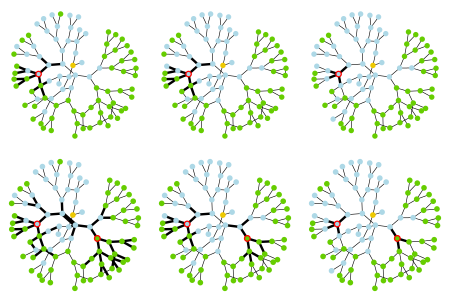

"/Users/mattiatarabolo/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/examples/backward_messages/mus_active_450x300.pdf"

In [48]:
gr()

spess = [1, 1, 10, 10, 10, 10, 60]

times = [t_obs-3, t_obs-2, t_obs-1]


######## 1 obs ##############
p1 = []
p2 = []

for t in times
    μ1 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μ1[i,j] += norm_μ(i,j,nodes1, t)
        μ1[j,i] += norm_μ(j,i,nodes1, t)
    end
    μ1 .+= μ1'

    μnz1 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μnz1[i,j] += check_μ_nonzero(i,j,nodes1, t)*1.8 + .3
        μnz1[j,i] += check_μ_nonzero(j,i,nodes1, t)*1.8 + .3
    end
    μnz1 .+= μnz1'

    cols = [config[i,t+1]==1.0 ? :blues : :chartreuse3 for i=1:NV]
    cols[isource] .= :gold2
    obswidth = [0.0 for _ in 1:NV]
    obswidth[observed1] .= 1.3
    markcol = [:auto for _ in 1:NV]
    markcol[observed1] .= :red
    markalpha = [0.0 for _ in 1:NV]
    markalpha[observed1] .= 1.0
    μs1 = spess[length(observed1)] * sparse((μ1)/maximum(μ1)) #qui ci metto lo spessore
    Random.seed!(1998)
    push!(p1, graphplot(G; edgewidth=(s,d,w) -> μnz1[s,d], margin=0Plots.mm, markercolor=cols, markersize=0.2, markerstrokecolor=markcol, markerstrokewidth=obswidth, markerstrokealpha=markalpha, edgecolor=:black, curves=false, nodeshape=:circle, axisbuffer=0.05))

    ######## 2 obs ##############
    μ2 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μ2[i,j] += norm_μ(i,j,nodes2,t)
        μ2[j,i] += norm_μ(j,i,nodes2,t)
    end
    μ2 .+= μ2'

    μnz2 = zeros(NV,NV)
    for e in edges(G)
        i = src(e)
        j = dst(e)
        μnz2[i,j] += check_μ_nonzero(i,j,nodes2,t)*1.8 + .3
        μnz2[j,i] += check_μ_nonzero(j,i,nodes2,t)*1.8 + .3
    end
    μnz2 .+= μnz2'

    cols = [config[i,t+1]==1.0 ? :blues : :chartreuse3 for i=1:NV]
    cols[isource] .= :gold2
    obswidth = [0.0 for _ in 1:NV]
    obswidth[observed2] .= 1.3
    markcol = [:auto for _ in 1:NV]
    markcol[observed2] .= :red
    markalpha = [0.0 for _ in 1:NV]
    markalpha[observed2] .= 1.0
    μs2 = spess[length(observed2)] * sparse((μ2)/maximum(μ2)) #qui ci metto lo spessore
    Random.seed!(1998)
    push!(p2, graphplot(G; edgewidth=(s,d,w) -> μnz2[s,d], margin=0Plots.mm, markercolor=cols, markersize = 0.2, markerstrokewidth=obswidth, markerstrokecolor=markcol, markerstrokealpha=markalpha,  edgecolor=:black, curves=false, nodeshape=:circle, axisbuffer=0.03))

end
    
########### final plot #####################
#ptot = plot(p1, p2, layout = (2, 3), size = (1200, 600), margin=0Plots.mm)
ptot = plot(p1[1], p1[2], p1[3], p2[1], p2[2], p2[3], layout = (2, 3), size = (450, 300), margin=0Plots.mm)
display(ptot)

Plots.svg(ptot, "mus_active_450x300.svg")
savefig(ptot, "mus_active_450x300.pdf")
